# Data Preparation

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 01.10.2022
- **Date of Last Modification:** 16.04.2023

## 1. Setup

### 1.1 Import Libraries

In [1]:
import os
import warnings
from copy import deepcopy

import anndata as ad
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import seaborn as sns
import squidpy as sq
import tiledb
import tiledbsoma

### 1.2 Run Notebook Setup

In [2]:
warnings.filterwarnings("ignore")

### 1.3 Configure Paths and Create Directories

In [3]:
# Define paths
srt_data_folder_path = "../datasets/srt_data" # spatially resolved transcriptomics data
srt_data_bronze_folder_path = f"{srt_data_folder_path}/bronze"
srt_data_silver_folder_path = f"{srt_data_folder_path}/silver"
srt_data_gold_folder_path = f"{srt_data_folder_path}/gold"

# Create required directories
os.makedirs(srt_data_bronze_folder_path, exist_ok=True)
os.makedirs(srt_data_silver_folder_path, exist_ok=True)
os.makedirs(srt_data_gold_folder_path, exist_ok=True)

## 2. Manuscript Data

This sections contains all datasets used for the manuscript.

### 2.1 seqFISH Mouse Organogenesis Dataset

- **Publication:** Lohoff, T. et al. Integration of spatial and single-cell transcriptomic data elucidates mouse organogenesis. Nat. Biotechnol. 40, 74–85 (2022): https://www.nature.com/articles/s41587-021-01006-2.
- **Data Access:** https://marionilab.cruk.cam.ac.uk/SpatialMouseAtlas/
    - Three embryos with two sections each can be downloaded
    - The two sections can be combined horizontally to get three datasets, one for each embryo
- **Data Structure:**
    - ```
         ├── ../datasets/srt_data/bronze
         │   └── seqfish_mouse_organogenesis  
         │        └── metadata.Rds (metadata)
         │        └── counts.Rds (raw counts)
         │        └── exprs.Rds (log normalized counts)
         │        └── imputed.h5 (imputed gene expression)
         │        └── imputed_row_names.Rds (row names of imputed gene expression)
         │        └── imputed_column_names.Rds (column names of imputed gene expression)
      ```
- **Summary:**
    - Sagittal tissue sections of three 8-12 somite stage mouse embryos
    - 19,451 observations (embryo 1), 14,891 observations (embryo 2) and 23,194 observations (embryo 3) on cell-level with cell-type annotations
    - 351 probed genes
    - Dataset is also available with imputed genes based on scRNA-seq

In [4]:
dataset = "seqfish_mouse_organogenesis"
cell_type_key = "celltype_mapped_refined"

#### 2.1.1 Load & Preprocess Raw Data

##### 2.1.1.1 ST Data

Preprocessing is done with ```../scripts/seqfish_mouse_organogenesis_data_preparation.R``` and preprocessed version is stored under ```../datasets/srt_data/silver/seqfish_mouse_organogenesis.h5ad```.

In [5]:
# Read preprocessed data
adata = sc.read_h5ad(f"{srt_data_silver_folder_path}/{dataset}.h5ad")

# Filter low quality cells
adata = adata[adata.obs["celltype_mapped_refined"] != "Low quality"]

# Format adata
adata.obsm["spatial"] = np.column_stack((adata.obs.x, adata.obs.y))
adata.obs.drop(["x", "y"], axis=1, inplace=True)
adata.X = adata.X.astype(np.float32)
adata.layers["counts"] = adata.layers["counts"].astype(np.float32)

# Add sample & batch columns
adata.obs.loc[adata.obs.index.str.contains("embryo1"), "sample"] = "embryo1"
adata.obs.loc[adata.obs.index.str.contains("embryo2"), "sample"] = "embryo2"
adata.obs.loc[adata.obs.index.str.contains("embryo3"), "sample"] = "embryo3"

adata.obs.loc[adata.obs.index.str.startswith("embryo1") &
              adata.obs.index.str.endswith("z2"), "batch"] = "embryo1_z2"
adata.obs.loc[adata.obs.index.str.startswith("embryo1") &
              adata.obs.index.str.endswith("z5"), "batch"] = "embryo1_z5"
adata.obs.loc[adata.obs.index.str.startswith("embryo2") &
              adata.obs.index.str.endswith("z2"), "batch"] = "embryo2_z2"
adata.obs.loc[adata.obs.index.str.startswith("embryo2") &
              adata.obs.index.str.endswith("z5"), "batch"] = "embryo2_z5"
adata.obs.loc[adata.obs.index.str.startswith("embryo3") &
              adata.obs.index.str.endswith("z2"), "batch"] = "embryo3_z2"
adata.obs.loc[adata.obs.index.str.startswith("embryo3") &
              adata.obs.index.str.endswith("z5"), "batch"] = "embryo3_z5"

# Write adata to disk separated by batches
batch_indeces = list(np.arange(6) + 1)
batches = ["embryo1_z2",
           "embryo1_z5",
           "embryo2_z2",
           "embryo2_z5",
           "embryo3_z2",
           "embryo3_z5"]

for batch_idx, batch in zip(batch_indeces, batches):
    adata_batch = adata[adata.obs["batch"] == batch]
    adata_batch.write(f"{srt_data_gold_folder_path}/{dataset}_batch{batch_idx}.h5ad")

KeyError: 'counts'

##### 2.1.1.1 ST Data Subsamples

In [9]:
adata_embryo1 = adata[adata.obs["sample"] == "embryo1"]
adata_embryo2 = adata[adata.obs["sample"] == "embryo2"]
adata_embryo3 = adata[adata.obs["sample"] == "embryo3"]

#adata_embryo1.write(f"{srt_data_gold_folder_path}/{dataset}_embryo1.h5ad")
adata_embryo2.write(f"{srt_data_gold_folder_path}/{dataset}_embryo2.h5ad")
#adata_embryo3.write(f"{srt_data_gold_folder_path}/{dataset}_embryo3.h5ad")

NameError: name 'adata' is not defined

##### 2.1.1.3 Imputed Data

In [16]:
# Read preprocessed imputed adata
adata_imputed = sc.read_h5ad(f"{srt_data_silver_folder_path}/{dataset}_imputed.h5ad")

# Filter low quality cells
adata_imputed = adata_imputed[adata_imputed.obs["celltype_mapped_refined"] != "Low quality"]

# Format imputed adata
adata_imputed.obsm["spatial"] = np.column_stack((adata_imputed.obs.x, adata_imputed.obs.y))
adata_imputed.obs.drop(["x", "y"], axis=1, inplace=True)
adata_imputed.X = adata_imputed.X.astype(np.float32)
adata_imputed.layers["log_normalized_counts"] = adata_imputed.X 

# Add sample & batch columns
adata_imputed.obs.loc[adata_imputed.obs.index.str.contains("embryo1"), "sample"] = "embryo1"
adata_imputed.obs.loc[adata_imputed.obs.index.str.contains("embryo2"), "sample"] = "embryo2"
adata_imputed.obs.loc[adata_imputed.obs.index.str.contains("embryo3"), "sample"] = "embryo3"

adata_imputed.obs.loc[adata_imputed.obs.index.str.startswith("embryo1") &
                      adata_imputed.obs.index.str.endswith("z2"), "batch"] = "embryo1_z2"
adata_imputed.obs.loc[adata_imputed.obs.index.str.startswith("embryo1") &
                      adata_imputed.obs.index.str.endswith("z5"), "batch"] = "embryo1_z5"
adata_imputed.obs.loc[adata_imputed.obs.index.str.startswith("embryo2") &
                      adata_imputed.obs.index.str.endswith("z2"), "batch"] = "embryo2_z2"
adata_imputed.obs.loc[adata_imputed.obs.index.str.startswith("embryo2") &
                      adata_imputed.obs.index.str.endswith("z5"), "batch"] = "embryo2_z5"
adata_imputed.obs.loc[adata_imputed.obs.index.str.startswith("embryo3") &
                      adata_imputed.obs.index.str.endswith("z2"), "batch"] = "embryo3_z2"
adata_imputed.obs.loc[adata_imputed.obs.index.str.startswith("embryo3") &
                      adata_imputed.obs.index.str.endswith("z5"), "batch"] = "embryo3_z5"

# Write adata to disk separated by batches
batch_indeces = list(np.arange(6) + 1)
batches = ["embryo1_z2",
           "embryo1_z5",
           "embryo2_z2",
           "embryo2_z5",
           "embryo3_z2",
           "embryo3_z5"]

for batch_idx, batch in zip(batch_indeces, batches):
    adata_imputed_batch = adata_imputed[adata_imputed.obs["batch"] == batch]
    adata_imputed_batch.write(f"{srt_data_gold_folder_path}/{dataset}_imputed_batch{batch_idx}.h5ad")

#### 2.1.2 Explore Data

In [ ]:
print(f"Exploring dataset {dataset}_embryo1.")
print(f"Number of nodes (cells): {adata_embryo1.layers['counts'].shape[0]}")
print(f"Number of node features (genes): {adata_embryo1.layers['counts'].shape[1]}")

# Visualize cell-level annotated data in physical space
sq.pl.spatial_scatter(adata_embryo1, color=cell_type_key, shape=None, figsize=(12, 12))

In [ ]:
print(f"Exploring dataset {dataset}_embryo2.")
print(f"Number of nodes (cells): {adata_embryo2.layers['counts'].shape[0]}")
print(f"Number of node features (genes): {adata_embryo2.layers['counts'].shape[1]}")

# Visualize cell-level annotated data in physical space
sq.pl.spatial_scatter(adata_embryo2, color=cell_type_key, shape=None, figsize=(12, 12))

In [ ]:
print(f"Exploring dataset {dataset}_embryo3.")
print(f"Number of nodes (cells): {adata_embryo3.layers['counts'].shape[0]}")
print(f"Number of node features (genes): {adata_embryo3.layers['counts'].shape[1]}")

# Visualize cell-level annotated data in physical space
sq.pl.spatial_scatter(adata_embryo3, color=cell_type_key, shape=None, figsize=(12, 12))

### 2.2 STARmap PLUS Mouse Central Nervous System Dataset

- **Publication:** Shi, H. et al. Spatial Atlas of the Mouse Central Nervous System at Molecular Resolution. bioRxiv 2022.06.20.496914 (2022). [doi:10.1101/2022.06.20.496914](https://doi.org/10.1101/2022.06.20.496914)
- **Data Access:** https://singlecell.broadinstitute.org/single_cell/study/SCP1830
- **Data Structure:**
    - ```
         ├── ../datasets/srt_data/bronze
         │   └── starmap_plus_mouse_cns  
         │        └── sagittal1raw_expression_pd.csv (gene expression)
         │        └── imputation_sagittal1.h5ad (imputed gene expression)
         │        └── sagittal1_spatial.csv (spatial coordinates)
         │        └── ...)
      ```
- **Summary:**
    - Benchmarking
        - Sagittal section of mouse brain (sagittal1)
        - 91,246 observations on cell level with cell type annotations
        - 1022 genes
    - Analysis
        - 20 transduced CNS tissue slices
        - 1,091,527 observations on cell level with cell type annotations
        - 11,844 imputed genes

In [4]:
dataset = "starmap_plus_mouse_cns"
cell_type_key = "Main_molecular_cell_type"
starmap_plus_dir = f"{srt_data_bronze_folder_path}/{dataset}/"

#### 2.2.1 Load & Preprocess Raw Data

##### 2.2.1.1 ST Data

In [ ]:
batch_indeces = list(np.arange(20) + 1)
batches = ["sagittal1",
           "sagittal2",
           "sagittal3",
           "spinalcord",
           "well01OB",
           "well01brain",
           "well03",
           "well04",
           "well05",
           "well06",
           "well07",
           "well08",
           "well09",
           "well10",
           "well11",
           "well1_5",
           "well2_5",
           "well3_5",
           "well7_5",
           "well10_5"]

for batch_idx, batch in zip(batch_indeces, batches):
    print(f"Loading, preprocessing and saving batch '{batch}'.")
    
    # Read counts and change format
    counts = pd.read_csv(starmap_plus_dir + f"{batch}raw_expression_pd.csv")
    counts.set_index("GENE", inplace=True)
    counts = counts.T

    # Read metadata and change format
    metadata = pd.read_csv(starmap_plus_dir + f"{batch}_spatial.csv", skiprows=[1])
    metadata.set_index("NAME", inplace=True)

    # Merge counts with metadata and store counts in `layers` and spatial coords in `obsm`
    adata = ad.AnnData(counts, dtype=np.float32)
    adata.obs = pd.merge(adata.obs, metadata, how="left", left_index=True, right_index=True)
    adata.obsm["spatial"] = adata.obs[["X", "Y"]].values / 1000 # smaller scale for plotting
    adata.obs.drop(columns=["X", "Y", "Z"], inplace=True)
    adata.X = sp.csr_matrix(adata.X) # sparse row format
    adata.layers["counts"] = adata.X.copy()
    
    # Preprocess adata
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.obs["batch"] = batch

    # Store adata to disk
    adata.write(f"{srt_data_gold_folder_path}/{dataset}_batch{batch_idx}.h5ad")

##### 2.2.1.2 ST Data Subsamples

In [ ]:
# Create sample of sagittal1 for individual sample benchmarking of non-scalable methods
adata = sc.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_batch1.h5ad")
adata_sample = adata[:18250, :] # ~20% of the dataset

# Store adata to disk
adata_sample.write(f"{srt_data_gold_folder_path}/{dataset}_sample.h5ad")

In [5]:
# Create sample (1%) of all batches for sample integration benchmarking of non-scalable methods
batch_indeces = list(np.arange(20) + 1)
batches = ["sagittal1",
           "sagittal2",
           "sagittal3",
           "spinalcord",
           "well01OB",
           "well01brain",
           "well03",
           "well04",
           "well05",
           "well06",
           "well07",
           "well08",
           "well09",
           "well10",
           "well11",
           "well1_5",
           "well2_5",
           "well3_5",
           "well7_5",
           "well10_5"]

for batch_idx, batch in zip(batch_indeces, batches):
    print(f"Loading, preprocessing and saving batch '{batch}'.")
    
    # Read counts and change format
    counts = pd.read_csv(starmap_plus_dir + f"{batch}raw_expression_pd.csv")
    counts.set_index("GENE", inplace=True)
    counts = counts.T

    # Read metadata and change format
    metadata = pd.read_csv(starmap_plus_dir + f"{batch}_spatial.csv", skiprows=[1])
    metadata.set_index("NAME", inplace=True)

    # Merge counts with metadata and store counts in `layers` and spatial coords in `obsm`
    adata = ad.AnnData(counts, dtype=np.float32)
    adata.obs = pd.merge(adata.obs, metadata, how="left", left_index=True, right_index=True)
    adata.obsm["spatial"] = adata.obs[["X", "Y"]].values / 1000 # smaller scale for plotting
    adata.obs.drop(columns=["X", "Y", "Z"], inplace=True)
    adata.X = sp.csr_matrix(adata.X) # sparse row format
    adata.layers["counts"] = adata.X.copy()
    
    # Preprocess adata
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.obs["batch"] = batch
    adata = adata[:int(0.01 * len(adata)),:]

    # Store adata to disk
    adata.write(f"{srt_data_gold_folder_path}/{dataset}_subsample_1pct_batch{batch_idx}.h5ad")

Loading, preprocessing and saving batch 'sagittal1'.
Loading, preprocessing and saving batch 'sagittal2'.
Loading, preprocessing and saving batch 'sagittal3'.
Loading, preprocessing and saving batch 'spinalcord'.
Loading, preprocessing and saving batch 'well01OB'.
Loading, preprocessing and saving batch 'well01brain'.
Loading, preprocessing and saving batch 'well03'.
Loading, preprocessing and saving batch 'well04'.
Loading, preprocessing and saving batch 'well05'.
Loading, preprocessing and saving batch 'well06'.
Loading, preprocessing and saving batch 'well07'.
Loading, preprocessing and saving batch 'well08'.
Loading, preprocessing and saving batch 'well09'.
Loading, preprocessing and saving batch 'well10'.
Loading, preprocessing and saving batch 'well11'.
Loading, preprocessing and saving batch 'well1_5'.
Loading, preprocessing and saving batch 'well2_5'.
Loading, preprocessing and saving batch 'well3_5'.
Loading, preprocessing and saving batch 'well7_5'.
Loading, preprocessing and

In [ ]:
# Create sample (5%) of all batches for sample integration benchmarking of non-scalable methods
batch_indeces = list(np.arange(20) + 1)
batches = ["sagittal1",
           "sagittal2",
           "sagittal3",
           "spinalcord",
           "well01OB",
           "well01brain",
           "well03",
           "well04",
           "well05",
           "well06",
           "well07",
           "well08",
           "well09",
           "well10",
           "well11",
           "well1_5",
           "well2_5",
           "well3_5",
           "well7_5",
           "well10_5"]

for batch_idx, batch in zip(batch_indeces, batches):
    print(f"Loading, preprocessing and saving batch '{batch}'.")
    
    # Read counts and change format
    counts = pd.read_csv(starmap_plus_dir + f"{batch}raw_expression_pd.csv")
    counts.set_index("GENE", inplace=True)
    counts = counts.T

    # Read metadata and change format
    metadata = pd.read_csv(starmap_plus_dir + f"{batch}_spatial.csv", skiprows=[1])
    metadata.set_index("NAME", inplace=True)

    # Merge counts with metadata and store counts in `layers` and spatial coords in `obsm`
    adata = ad.AnnData(counts, dtype=np.float32)
    adata.obs = pd.merge(adata.obs, metadata, how="left", left_index=True, right_index=True)
    adata.obsm["spatial"] = adata.obs[["X", "Y"]].values / 1000 # smaller scale for plotting
    adata.obs.drop(columns=["X", "Y", "Z"], inplace=True)
    adata.X = sp.csr_matrix(adata.X) # sparse row format
    adata.layers["counts"] = adata.X.copy()
    
    # Preprocess adata
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.obs["batch"] = batch
    adata = adata[:int(0.05 * len(adata)),:]

    # Store adata to disk
    adata.write(f"{srt_data_gold_folder_path}/{dataset}_subsample_5pct_batch{batch_idx}.h5ad")

##### 2.2.1.3 Imputed Data

In [ ]:
batch_indeces = [1, 2, 3]
batches = ["sagittal1", "sagittal2", "sagittal3"]
for batch_idx, batch in zip(batch_indeces, batches):
    print(f"Loading, preprocessing and saving batch '{batch}'.")    
    
    # Read adata
    adata_imputed = sc.read_h5ad(starmap_plus_dir + f"imputation_{batch}.h5ad")

    # Read metadata and change format
    metadata = pd.read_csv(starmap_plus_dir + f"{batch}_spatial.csv", skiprows=[1])
    metadata.set_index("NAME", inplace=True)

    # Merge adata with metadata
    adata_imputed.obs = pd.merge(adata_imputed.obs,
                                 metadata,
                                 how="left",
                                 left_index=True,
                                 right_index=True)
    
    # Format adata
    adata_imputed.var_names = adata_imputed.var["Gene"]
    adata_imputed.X = adata_imputed.X.astype(np.float32)
    adata_imputed.X = (
        adata_imputed.X * np.array(adata_imputed.var["std"])) # Undo std scaling of data with sc.pp.scale()
    adata_imputed.X = (
        adata_imputed.X + np.abs(np.array(adata_imputed.X.min(axis=0)))) # Undo mean scaling of data with sc.pp.scale()
    
    # Threshold gene expression values to create a sparse row matrix
    adata = sc.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_batch{batch_idx}.h5ad")
    avg_nnz_per_gene = round(adata.X.nnz / adata.X.shape[1]) 
    zero_threshs = np.partition(
        adata_imputed.X, -avg_nnz_per_gene, axis=0)[-avg_nnz_per_gene,:] # threshhold based on the 'avg_nnz_per_gene'th
                                                                         # largest value per gene to arrive at an equal nnz per gene
    adata_imputed.X[adata_imputed.X < zero_threshs] = 0
    adata_imputed.X = sp.csr_matrix(adata_imputed.X)
    adata_imputed.var.drop(columns=["Gene", "mean", "std"], inplace=True)
    adata_imputed.obsm["spatial"] = adata_imputed.obs[["X", "Y"]].values / 1000 # smaller scale for plotting with squidpy
    adata_imputed.obs.drop(columns=["X", "Y", "Z"], inplace=True)
    adata_imputed.obs["batch"] = batch

    # Store adata to disk
    adata_imputed.write(f"{srt_data_gold_folder_path}/{dataset}_batch{batch_idx}_imputed.h5ad")

#### 2.2.2 Explore Data

##### 2.2.2.1 ST Data

In [ ]:
print(f"Exploring dataset {dataset}.")
print(f"Number of nodes (cells): {adata.layers['counts'].shape[0]}")
print(f"Number of node features (genes): {adata.layers['counts'].shape[1]}")

# Visualize cell-level annotated data in physical space
sq.pl.spatial_scatter(adata, color=cell_type_key, shape=None, figsize=(12, 12))

In [ ]:
print(f"Exploring dataset {dataset} sample.")
print(f"Number of nodes (cells): {adata_sample.layers['counts'].shape[0]}")
print(f"Number of node features (genes): {adata_sample.layers['counts'].shape[1]}")

# Visualize cell-level annotated data in physical space
sq.pl.spatial_scatter(adata_sample, color=cell_type_key, shape=None, figsize=(12, 12))

In [ ]:
print(f"Exploring dataset {dataset}_batch1_imputed.")
print(f"Number of nodes (cells): {adata_batch1_imputed.layers['log_normalized_counts'].shape[0]}")
print(f"Number of node features (genes): {adata_batch1_imputed.layers['log_normalized_counts'].shape[1]}")

# Visualize cell-level annotated data in physical space
sq.pl.spatial_scatter(adata_batch1_imputed, color=cell_type_key, shape=None, figsize=(12, 12))

In [ ]:
print(f"Exploring dataset {dataset}_batch2_imputed.")
print(f"Number of nodes (cells): {adata_batch2_imputed.layers['log_normalized_counts'].shape[0]}")
print(f"Number of node features (genes): {adata_batch2_imputed.layers['log_normalized_counts'].shape[1]}")

# Visualize cell-level annotated data in physical space
sq.pl.spatial_scatter(adata_batch2_imputed, color=cell_type_key, shape=None, figsize=(12, 12))

In [ ]:
print(f"Exploring dataset {dataset}_batch3_imputed.")
print(f"Number of nodes (cells): {adata_batch3_imputed.layers['log_normalized_counts'].shape[0]}")
print(f"Number of node features (genes): {adata_batch3_imputed.layers['log_normalized_counts'].shape[1]}")

# Visualize cell-level annotated data in physical space
sq.pl.spatial_scatter(adata_batch3_imputed, color=cell_type_key, shape=None, figsize=(12, 12))

In [ ]:
print(f"Exploring dataset {dataset}_batch4_imputed.")
print(f"Number of nodes (cells): {adata_batch4_imputed.layers['log_normalized_counts'].shape[0]}")
print(f"Number of node features (genes): {adata_batch4_imputed.layers['log_normalized_counts'].shape[1]}")

# Visualize cell-level annotated data in physical space
sq.pl.spatial_scatter(adata_batch4_imputed, color=cell_type_key, shape=None, figsize=(12, 12))

In [ ]:
print(f"Exploring dataset {dataset}_batch5_imputed.")
print(f"Number of nodes (cells): {adata_batch5_imputed.layers['log_normalized_counts'].shape[0]}")
print(f"Number of node features (genes): {adata_batch5_imputed.layers['log_normalized_counts'].shape[1]}")

# Visualize cell-level annotated data in physical space
sq.pl.spatial_scatter(adata_batch5_imputed, color=cell_type_key, shape=None, figsize=(12, 12))

In [ ]:
print(f"Exploring dataset {dataset}_batch6_imputed.")
print(f"Number of nodes (cells): {adata_batch6_imputed.layers['log_normalized_counts'].shape[0]}")
print(f"Number of node features (genes): {adata_batch6_imputed.layers['log_normalized_counts'].shape[1]}")

# Visualize cell-level annotated data in physical space
sq.pl.spatial_scatter(adata_batch6_imputed, color=cell_type_key, shape=None, figsize=(12, 12))

In [ ]:
print(f"Exploring dataset {dataset}_batch6_imputed.")
print(f"Number of nodes (cells): {adata_imputed.layers['log_normalized_counts'].shape[0]}")
print(f"Number of node features (genes): {adata_imputed.layers['log_normalized_counts'].shape[1]}")

# Visualize cell-level annotated data in physical space
sq.pl.spatial_scatter(adata_imputed, color=cell_type_key, shape=None, figsize=(12, 12))

### 2.3 Vizgen MERFISH Mouse Liver Dataset

- **Publication**: Vizgen MERFISH Mouse Liver Map January 2022
- **Data Access:** https://info.vizgen.com/mouse-liver-access
    - Animal 1 replicate 1 is used
    - 2 animals with 2 replicates each can be downloaded
- **Data Structure:**
    - ```
         ├── ../datasets/srt_data/bronze
         │   └── vizgen_merfish_mouse_liver  
         │        └── cell_by_gene.csv (gene expression)
         │        └── cell_metadata.csv (metadata) 
      ```
- **Preprocessing Vignette:** https://squidpy.readthedocs.io/en/latest/external_tutorials/tutorial_vizgen_mouse_liver.html
- **Summary:**
    - Liver tissue section of mouse liver map
    - 367,335 observations on cell-level with cell-type annotations
    - 347 probed genes

In [ ]:
dataset = "vizgen_merfish_mouse_liver"
cell_type_key = "Cell_Type"

#### 2.3.1 Load & Preprocess Raw Data

In [ ]:
merfish_dir = f"{srt_data_bronze_folder_path}/{dataset}/"

In [ ]:
print(f"Loading and preprocessing dataset '{dataset}'.")
    
# Read adata from files
adata = sq.read.vizgen(merfish_dir,
                       counts_file="Liver1Slice1_cell_by_gene.csv",
                       meta_file="Liver1Slice1_cell_metadata.csv")

# Preprocess as per squidpy vignette
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"],percent_top=(50, 100, 200, 300), inplace=True)
sc.pp.filter_cells(adata, min_counts=50)
sc.pp.filter_genes(adata, min_cells=10)

# Store raw counts in `layers`
adata.layers["counts"] = adata.X.copy()

# Store data to disk
adata.write(f"{srt_data_silver_folder_path}/{dataset}.h5ad")

# Determine cell annotation as per squidpy vignette
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=1.5)

sc.set_figure_params(figsize=(10,10))
sc.pl.umap(adata, color=["leiden"], size=5)

gene_panel = "https://static-content.springer.com/esm/art%3A10.1038%2Fs41421-021-00266-1/MediaObjects/41421_2021_266_MOESM1_ESM.xlsx"
df_ref_panel_ini = pd.read_excel(gene_panel, index_col=0)
df_ref_panel = df_ref_panel_ini.iloc[1:,:1]
df_ref_panel.index.name = None
df_ref_panel.columns = ["Function"]

# Assign marker gene metadata using reference dataset
marker_genes = df_ref_panel[df_ref_panel["Function"].str.contains("marker")].index.tolist()

meta_gene = deepcopy(adata.var)
common_marker_genes = list(set(meta_gene.index.tolist()).intersection(marker_genes))
meta_gene.loc[common_marker_genes, "Markers"] = df_ref_panel.loc[common_marker_genes, "Function"]
meta_gene["Markers"] = meta_gene["Markers"].apply(lambda x: "N.A." if "marker" not in str(x) else x)
meta_gene["Markers"].value_counts()

ser_counts = adata.obs["leiden"].value_counts()
ser_counts.name = "cell counts"
meta_leiden = pd.DataFrame(ser_counts)

cat_name = "leiden"
sig_leiden = pd.DataFrame(columns=adata.var_names, index=adata.obs[cat_name].cat.categories)
for clust in adata.obs[cat_name].cat.categories:
    sig_leiden.loc[clust] = adata[adata.obs[cat_name].isin([clust]),:].X.mean(0)
sig_leiden = sig_leiden.transpose()
leiden_clusters = ["Leiden-" + str(x) for x in sig_leiden.columns.tolist()]
sig_leiden.columns = leiden_clusters
meta_leiden.index = sig_leiden.columns.tolist()
meta_leiden["leiden"] = pd.Series(meta_leiden.index.tolist(), index=meta_leiden.index.tolist())

meta_gene = pd.DataFrame(index=sig_leiden.index.tolist())
meta_gene["info"] = pd.Series("", index=meta_gene.index.tolist())
meta_gene["Markers"] = pd.Series("N.A.", index=sig_leiden.index.tolist())
meta_gene.loc[common_marker_genes, "Markers"] = df_ref_panel.loc[common_marker_genes, "Function"]

meta_leiden["Cell_Type"] = pd.Series("N.A.", index=meta_leiden.index.tolist())
num_top_genes = 30
for inst_cluster in sig_leiden.columns.tolist():
    top_genes = sig_leiden[inst_cluster].sort_values(ascending=False).index.tolist()[:num_top_genes]

    inst_ser = meta_gene.loc[top_genes, "Markers"]
    inst_ser = inst_ser[inst_ser != "N.A."]
    ser_counts = inst_ser.value_counts()
  
    max_count = ser_counts.max()
  
    max_cat = "_".join(sorted(ser_counts[ser_counts == max_count].index.tolist()))
    max_cat = max_cat.replace(" marker", "").replace(" ", "-")
  
    print(inst_cluster, max_cat)
    meta_leiden.loc[inst_cluster, "Cell_Type"] = max_cat

# Rename clusters
meta_leiden["name"] = meta_leiden.apply(lambda x: x["Cell_Type"] + "_" + x["leiden"] , axis=1)
leiden_names = meta_leiden["name"].values.tolist()
meta_leiden.index = leiden_names

# Transfer cell type labels to single cells
leiden_to_cell_type = deepcopy(meta_leiden)
leiden_to_cell_type.set_index("leiden", inplace=True)
leiden_to_cell_type.index.name = None

adata.obs["Cell_Type"] = adata.obs["leiden"].apply(lambda x: leiden_to_cell_type.loc["Leiden-" + str(x), "Cell_Type"])
adata.obs["Cluster"] = adata.obs["leiden"].apply(lambda x: leiden_to_cell_type.loc["Leiden-" + str(x), "name"])

In [ ]:
adata_old = adata.copy()

In [ ]:
adata = ad.AnnData(sp.csr_matrix(adata_old.X))
adata.obs_names = adata_old.obs_names
adata.var_names = adata_old.var_names

adata.layers["counts"] = adata_old.layers["counts"]
adata.obsm["spatial"] = adata_old.obsm["spatial"]
adata.obs["Cell_Type"] = adata_old.obs["Cell_Type"]

# Remove negative probes
adata = adata[:, ~adata.var_names.str.contains("Blank")]

adata.obs["batch"] = "animal1_z2"

# Store gene expression in sparse row format
adata.layers["counts"] = sp.csr_matrix(adata.layers["counts"])

# Add field of view
adata.obs["fov"] = adata_old.obs["fov"].values

# Store data to disk
adata.write(f"{srt_data_gold_folder_path}/{dataset}.h5ad")

In [ ]:
# Create sample for non-scalable methods
adata.obs["fov"] = adata_old.obs["fov"].values
adata_sample = adata[(adata.obs["fov"] <= 188)] # ~10% of the dataset

# Store data to disk
adata_sample.write(f"{srt_data_gold_folder_path}/{dataset}_sample.h5ad")

#### 2.3.2 Explore Data

In [ ]:
print(f"Exploring dataset {dataset}.")
print(f"Number of nodes (cells): {adata.layers['counts'].shape[0]}")
print(f"Number of node features (genes): {adata.layers['counts'].shape[1]}")

# Visualize cell-level annotated data in physical space
sq.pl.spatial_scatter(adata, color=cell_type_key, shape=None, figsize=(12, 12))

In [ ]:
print(f"Exploring dataset {dataset} sample.")
print(f"Number of nodes (cells): {adata_sample.layers['counts'].shape[0]}")
print(f"Number of node features (genes): {adata_sample.layers['counts'].shape[1]}")

# Visualize cell-level annotated data in physical space
sq.pl.spatial_scatter(adata_sample, color=cell_type_key, shape=None, figsize=(12, 12))

### 2.4 nanoString CosMx SMI Human Non-Small-Cell Lung Cancer (NSCLC)

- **Publication:** Tang, Z., Zhang, T., Yang, B., Su, J. & Song, Q. SiGra: Single-cell spatial elucidation through image-augmented graph transformer. bioRxiv (2022). [doi:10.1101/2022.08.18.504464v1](https://www.biorxiv.org/content/10.1101/2022.08.18.504464v1)
- **Data Access:** Preprocessed version from SiGra (https://purdue0-my.sharepoint.com/:f:/g/personal/tang385_purdue_edu/EoJcJv8OZHRIhLyplj5r1PABW-UQfD1p1YU00gAdZNeK7A?e=K3Mmqg (original source https://nanostring.com/products/cosmx-spatial-molecular-imager/ffpe-dataset/)
    - Lung 9 (replicate 1)
- **Data Structure**:
    - ```
         ├── ../datasets/srt_data/bronze
         │   └── nanostring_cosmx_human_nsclc  
         │        └── Lung9_Rep1_exprMat_file.csv (gene expression)
         │        └── matched_annotation_all.csv (cell annotations)
         │        └── fov1  
         │              ├── CellComposite_F001.jpg (histology image)
         │        └── fov2  
         │              ├── CellComposite_F002.jpg  
         │        └── ...  
         │        └── fov20  
         │              ├── ...  
      ```
- **Summary:**
    - Non-small-cell lung cancer of human
    - 83,621 observations on cell-level with cell-type annotations across 20 fovs
    - 960 genes

In [ ]:
dataset = "nanostring_cosmx_human_nsclc"
cell_type_key = "cell_type"

#### 2.4.1 Load & Preprocess Raw Data

In [ ]:
# Define field of views and images
fovs = ["fov1", "fov2", "fov3", "fov4", "fov5",
        "fov6", "fov7", "fov8", "fov9", "fov10",
        "fov11", "fov12", "fov13", "fov14", "fov15",
        "fov16", "fov17", "fov18", "fov19", "fov20"]

imgs = ["F001", "F002", "F003", "F004", "F005",
        "F006", "F007", "F008", "F009", "F010",
        "F011", "F012", "F013", "F014", "F015",
        "F016", "F017", "F018", "F019", "F020",]

In [ ]:
nanostring_dir = f"{srt_data_bronze_folder_path}/{dataset}/"

In [ ]:
def process_nanostring_cosmx_nsclc_data(fov, fov_id, img_id, coords="global"):
    # Read image
    img_path = os.path.join(nanostring_dir, fov_id, f"CellComposite_{img_id}.jpg")
    img = cv2.imread(img_path)
    height, width, c = img.shape

    # Read gene expression counts and filter for current field of view
    gene_expr = pd.read_csv(nanostring_dir + "Lung9_Rep1_exprMat_file.csv", delimiter=",")
    gene_expr_fov1 = gene_expr[gene_expr["fov"] == fov]
    gene_expr_fov1 = gene_expr_fov1.drop(columns=["fov"])
    gene_expr_fov1 = gene_expr_fov1.set_index("cell_ID")
    idx = gene_expr_fov1.index

    # Read annotations and filter for current field of view
    annotation = pd.read_csv(nanostring_dir + "matched_annotation_all.csv")
    annotation_fov1 = annotation[annotation["fov"] == int(fov)]

    # Define width and height for each image patch
    w, h = 60, 60

    # Get center of each cell and match to images
    for i, row in annotation_fov1.iterrows():
        cx, cy = float(annotation_fov1["CenterX_local_px"][i]), float(annotation_fov1["CenterY_local_px"][i])
        annotation_fov1["CenterY_local_px"][i] = height - float(annotation_fov1["CenterY_local_px"][i])

        if cx - w < 0 or cx + w > width or cy - h < 0 or cy + h > height:
            annotation_fov1["cell_type"][i] = np.nan
    annotation_fov1 = annotation_fov1.set_index("cell_ID").reindex(idx)

    # If annotation is NaN, drop corresponding row in gene expression df
    gene_expr_fov1["cell_type"] = annotation_fov1["cell_type"]
    gene_expr_fov1["niche"] = annotation_fov1["niche"]
    gene_expr_fov1 = gene_expr_fov1.dropna(axis=0, how="any")
    gene_expr_fov1 = gene_expr_fov1.drop(columns=["cell_type", "niche"])

    # Build adata
    adata = ad.AnnData(gene_expr_fov1)
    annotation_fov1.index = annotation_fov1.index.map(str)
    adata.obs["cell_type"] = annotation_fov1.loc[adata.obs_names, "cell_type"]
    adata.obs["niche"] = annotation_fov1.loc[adata.obs_names, "niche"]

    adata.obs["cx"] = annotation_fov1.loc[adata.obs_names, "CenterX_local_px"]
    adata.obs["cy"] = annotation_fov1.loc[adata.obs_names, "CenterY_local_px"]

    adata.obs["cx_g"] = annotation_fov1.loc[adata.obs_names, "CenterX_global_px"]
    adata.obs["cy_g"] = annotation_fov1.loc[adata.obs_names, "CenterY_global_px"]

    # Store coordinates in 'adata.obsm'
    if coords=="local":
        df = pd.DataFrame(index=adata.obs.index)
        df["cx"] = adata.obs["cx"] # local coordinate
        df["cy"] = adata.obs["cy"] # local coordinate
        adata.obsm["spatial"] = df.to_numpy()

    elif coords=="global":
        df = pd.DataFrame(index=adata.obs.index)
        df["cx_g"] = adata.obs["cx_g"]
        df["cy_g"] = adata.obs["cy_g"]
        adata.obsm["spatial"] = df.to_numpy()

    # Remove negative probes
    adata = adata[:, ~adata.var_names.str.contains("NegPrb")]

    # Store counts in adata.layers
    adata.layers["counts"] = adata.X.copy()
    
    # Normalize counts
    sc.pp.normalize_total(adata, target_sum=1e4)

    # Log-transform the normalized counts
    sc.pp.log1p(adata)
    
    adata.obs["batch"] = "lung9_rep1"

    adata.obs = adata.obs.drop(columns=["cx", "cy", "cx_g", "cy_g"])
    
    return adata

In [ ]:
# Preprocess all fovs and combine them
adata_fov_list = []

for fov, fov_id, img_id in zip(np.arange(1,21), fovs, imgs):
    adata_fov = process_nanostring_cosmx_nsclc_data(fov, fov_id, img_id)
    adata_fov_list.append(adata_fov)

adata = ad.concat(adata_fov_list, join="inner")

In [ ]:
# Store gene expression in sparse row format
adata.X = sp.csr_matrix(adata.X)
adata.layers["counts"] = sp.csr_matrix(adata.layers["counts"])

# Store data to disk
adata.write(f"{srt_data_gold_folder_path}/{dataset}.h5ad")

In [ ]:
# Create sample for non-scalable methods
adata_sample = ad.concat(adata_fov_list[:4], join="inner") # first fov that leads to >20% of the dataset

# Store gene expression in sparse row format
adata_sample.X = sp.csr_matrix(adata_sample.X)
adata_sample.layers["counts"] = sp.csr_matrix(adata_sample.layers["counts"])

# Store data to disk
adata_sample.write(f"{srt_data_gold_folder_path}/{dataset}_sample.h5ad")

#### 2.4.2 Explore Data

In [ ]:
print(f"Exploring dataset {dataset}.")
print(f"Number of nodes (cells): {adata.layers['counts'].shape[0]}")
print(f"Number of node features (genes): {adata.layers['counts'].shape[1]}")

# Visualize cell-level annotated data in physical space
sq.pl.spatial_scatter(adata, color=cell_type_key, shape=None, figsize=(12, 12))

In [ ]:
print(f"Exploring dataset {dataset} sample.")
print(f"Number of nodes (cells): {adata_sample.layers['counts'].shape[0]}")
print(f"Number of node features (genes): {adata_sample.layers['counts'].shape[1]}")

# Visualize cell-level annotated data in physical space
sq.pl.spatial_scatter(adata_sample, color=cell_type_key, shape=None, figsize=(12, 12))

### 2.5 Slide-seqV2 Mouse Hippocampus Dataset

- **Publication**: Stickels, R. R. et al. Highly sensitive spatial transcriptomics at near-cellular resolution with Slide-seqV2. Nat. Biotechnol. 39, 313–319 (2021). [doi:10.1038/s41587-020-0739-1](https://doi.org/10.1038/s41587-020-0739-1)
- **Data Access:** Preprocessed version from squidpy API (original source https://singlecell.broadinstitute.org/single_cell/study/SCP815/highly-sensitive-spatial-transcriptomics-at-near-cellular-resolution-with-slide-seqv2)
- **Summary:**
    - Mouse hippocampus puck
    - 41,786 observations on cell-level with cell-type annotations
    - 4,000 probed genes

In [ ]:
dataset = "slideseqv2_mouse_hippocampus"
cell_type_key = "cluster"

#### 2.5.1 Load & Preprocess Raw Data

In [ ]:
print(f"Loading and preprocessing dataset '{dataset}'.")

# Retrieve adata from squidpy
adata = sq.datasets.slideseqv2()

# Create new adata to drop all unnecessary columns
adata_new = sc.AnnData(sp.csr_matrix(
    (adata.shape[0], adata.shape[1]),
    dtype=np.float32))
adata_new.X = adata.X
adata_new.var_names = adata.var_names
adata_new.obs_names = adata.obs_names
adata_new.obsm["spatial"] = adata.obsm["spatial"]
adata_new.obs["cell_type"] = adata.obs["cluster"].values

# Store raw counts in adata.layers
adata_new.layers["counts"] = adata.raw[:, adata.raw.var_names.isin(adata.var_names)].X

adata_new.obs["batch"] = "sample1"

# Store data to disk
adata_new.write(f"{srt_data_gold_folder_path}/{dataset}.h5ad")

In [ ]:
# ~50 of the dataset
y_max_sample = max(adata.obs.y) - 1406
y_min_sample = min(adata.obs.y) + 1406
adata_sample = adata[(adata.obs.y < y_max_sample) & (adata.obs.y > y_min_sample)]

# Create new adata to drop all unnecessary columns
adata_new_sample = sc.AnnData(sp.csr_matrix(
    (adata_sample.shape[0], adata_sample.shape[1]),
    dtype=np.float32))
adata_new_sample.X = adata_sample.X
adata_new_sample.var_names = adata_sample.var_names
adata_new_sample.obs_names = adata_sample.obs_names
adata_new_sample.obsm["spatial"] = adata_sample.obsm["spatial"]
adata_new_sample.obs["cell_type"] = adata_sample.obs["cluster"].values

# Store raw counts in adata.layers
adata_new_sample.layers["counts"] = adata_sample.raw[
    :, adata_sample.raw.var_names.isin(adata_sample.var_names)].X

adata_new_sample.obs["batch"] = "sample1"

# Store data to disk
adata_new_sample.write(f"{srt_data_gold_folder_path}/{dataset}_sample.h5ad")

#### 2.5.2 Explore Data

In [ ]:
print(f"Exploring dataset {dataset}.")
print(f"Number of nodes (cells): {adata.X.shape[0]}")
print(f"Number of node features (genes): {adata.X.shape[1]}")

# Visualize cell-level annotated data in physical space
sq.pl.spatial_scatter(adata, color=cell_type_key, shape=None, figsize=(12, 12))

In [ ]:
print(f"Exploring dataset {dataset} sample.")
print(f"Number of nodes (cells): {adata_sample.X.shape[0]}")
print(f"Number of node features (genes): {adata_sample.X.shape[1]}")

# Visualize cell-level annotated data in physical space
sq.pl.spatial_scatter(adata_sample, color=cell_type_key, shape=None, figsize=(12, 12))

### 2.6 nanoString CosMx SMI Human Liver

- **Publication:** nanoString CosMx SMI Human Liver FFPE Dataset
- **Data Access:** https://nanostring.com/products/cosmx-spatial-molecular-imager/human-liver-rna-ffpe-dataset/
- **Data Structure**:
    - ```
         ├── ../datasets/srt_data/bronze
         │   └── nanostring_cosmx_human_liver
         │        └── LiverDataRelease 
      ```
- **Preprocessing Vignette**: https://nanostring.com/wp-content/uploads/2023/01/LiverPublicDataRelease.html
- **Summary:**
    - 2 samples: normal human liver (healthy sample) & human hepatocellular carcinoma (disease sample)
    - 332,877 observations (healthy sample) & 460,441 observations (disease sample) on cell-level with cell-type annotations
    - 1000 genes

In [ ]:
dataset = "nanostring_cosmx_human_liver"
cell_type_key = "cellType"

#### 2.6.1 Load & Preprocess Raw Data

In [ ]:
config = tiledb.Config()
ctx = tiledb.Ctx(config)

# Read in SOMACollection
pySoma = tiledbsoma.SOMACollection(f"{srt_data_bronze_folder_path}/nanostring_cosmx_human_liver/LiverDataRelease", ctx=ctx)
pySoma.keys()

# Raw counts
counts = pySoma['RNA'].X['counts'].csr()
counts

# Normalized counts
norm = pySoma['RNA_normalized'].X['data'].csr()
norm

# Cell metadata
obs = pySoma['RNA'].obs.df()
obs.head()

# Target transcript coordinates
transcriptCoords = tiledb.open_dataframe(pySoma['RNA'].obsm["transcriptCoords"].uri, ctx=ctx)
transcriptCoords

# Convert to adata
coordinates = np.array(obs[["x_slide_mm", "y_slide_mm"]])
adata = ad.AnnData(norm, obs = obs, obsm={"spatial": coordinates}, dtype = "float32")
adata.layers["counts"] = counts
adata.obs = adata.obs[["fov", "cellType", "niche"]]
adata.var_names = pySoma["RNA"].var_names

adata.X = adata.X.astype(np.float32)
adata.layers["counts"] = adata.layers["counts"].astype(np.float32)

adata_sample1 = adata[adata.obs.index.str.startswith("c_1")]
adata_sample2 = adata[adata.obs.index.str.startswith("c_2")]

adata_sample1.obs["batch"] = "sample1"
adata_sample2.obs["batch"] = "sample2"

adata_sample1.write(f"{srt_data_gold_folder_path}/{dataset}_sample1.h5ad")
adata_sample2.write(f"{srt_data_gold_folder_path}/{dataset}_sample2.h5ad")

#### 2.6.2 Explore Data

In [ ]:
print(f"Exploring dataset {dataset}_sample1.")
print(f"Number of nodes (cells): {adata_sample1.layers['counts'].shape[0]}")
print(f"Number of node features (genes): {adata_sample1.layers['counts'].shape[1]}")

# Visualize cell-level annotated data in physical space
sq.pl.spatial_scatter(adata_sample1, color=cell_type_key, shape=None, figsize=(12, 12))

In [ ]:
print(f"Exploring dataset {dataset}_sample2.")
print(f"Number of nodes (cells): {adata_sample2.layers['counts'].shape[0]}")
print(f"Number of node features (genes): {adata_sample2.layers['counts'].shape[1]}")

# Visualize cell-level annotated data in physical space
sq.pl.spatial_scatter(adata_sample2, color=cell_type_key, shape=None, figsize=(12, 12))

### 2.7 Spatial ATAC-RNA-Seq Mouse Embryo & Brain Dataset

- **Publication:** Zhang, D. et al. Spatial epigenome–transcriptome co-profiling of mammalian tissues. Nature 1–10 (2023): https://www.nature.com/articles/s41586-023-05795-1.
- **Data Access:** https://brain-spatial-omics.cells.ucsc.edu
- **Data Structure:**
    - ```
         ├── ../datasets/srt_data/bronze
         │   └── spatial_atac_rna_seq_mouse_embryo_and_brain  
         │        └── exprMatrix_e13.tsv (rna log normalized counts)
         │        └── exprMatrix_p21 (rna log normalized counts)
         │        └── exprMatrix_p22 (rna log normalized counts)
         │        └── Spots.coords_e13.tsv (spatial coordinates)
         │        └── Spots.coords_p21.tsv (spatial coordinates)
         │        └── Spots.coords_p22.tsv (spatial coordinates)
         │        └── meta_e13.tsv (metadata)
         │        └── meta_p21.tsv (metadata)
         │        └── meta_p22.tsv (metadata)
      ```
- **Summary:**
    - Embryonic day 13 (E13) mouse embryo, (pixel size, 50 μm), mouse postnatal day 21/22 (P21/22) brains (pixel size, 20 μm)
    - Also available: histone modification modality for mice; adult human brain  hippocampus tissue (pixel size, 50 μm)

In [4]:
dataset = "spatial_atac_rna_seq_mouse_embryo_and_brain"

#### 2.7.1 Load & Preprocess Raw Data

In [31]:
# Write adata to disk separated by batches
batch_indeces = list(np.arange(3) + 1)
batches = ["e13",
           "p21",
           "p22"]

for batch_idx, batch in zip(batch_indeces, batches):
    adata = sc.read_text(f"{srt_data_bronze_folder_path}/spatial_atac_rna_seq_mouse_embryo_and_brain/exprMatrix_{batch}.tsv.gz")
    coords = pd.read_csv(
        f"{srt_data_bronze_folder_path}/spatial_atac_rna_seq_mouse_embryo_and_brain/Spots.coords_{batch}.tsv.gz",
        sep="\t",
        header=None)
    meta = pd.read_csv(f"{srt_data_bronze_folder_path}/spatial_atac_rna_seq_mouse_embryo_and_brain/meta_{batch}.tsv",
                       sep="\t")
    adata.var = meta

    adata_rna = sc.AnnData(sp.csr_matrix(
                adata[["atac" not in gene for gene in adata.obs.index]].X.T,
                dtype=np.float32))
    adata_rna.var = adata[["atac" not in gene for gene in adata.obs.index]].obs
    adata_rna.obs = adata[["atac" not in gene for gene in adata.obs.index]].var
    adata_rna.obs.index = adata_rna.obs[adata_rna.obs.columns[0]]
    adata_rna.obs = adata_rna.obs.drop(adata_rna.obs.columns[0], axis=1)
    adata_rna.obsm["spatial"] = coords.iloc[:, 1:3].values
    adata_rna.write(f"{srt_data_gold_folder_path}/{dataset}_batch{batch_idx}_rna.h5ad")
    
    
    adata_atac = sc.AnnData(sp.csr_matrix(
                adata[["atac" in gene for gene in adata.obs.index]].X.T,
                dtype=np.float32))
    adata_atac.var = adata[["atac" in gene for gene in adata.obs.index]].obs
    adata_atac.obs = adata[["atac" in gene for gene in adata.obs.index]].var
    adata_atac.obs.index = adata_atac.obs[adata_atac.obs.columns[0]]
    adata_atac.obs = adata_atac.obs.drop(adata_atac.obs.columns[0], axis=1)
    adata_atac.obsm["spatial"] = coords.iloc[:, 1:3].values
    adata_atac.write(f"{srt_data_gold_folder_path}/{dataset}_batch{batch_idx}_atac.h5ad")

Exploring dataset spatial_atac_rna_seq_mouse_embryo_and_brain_batch1_rna .
Number of nodes (cells): 2187
Number of node features (genes): 15748
Exploring dataset spatial_atac_rna_seq_mouse_embryo_and_brain_batch2_rna .
Number of nodes (cells): 2373
Number of node features (genes): 19859
Exploring dataset spatial_atac_rna_seq_mouse_embryo_and_brain_batch3_rna .
Number of nodes (cells): 9215
Number of node features (genes): 18005


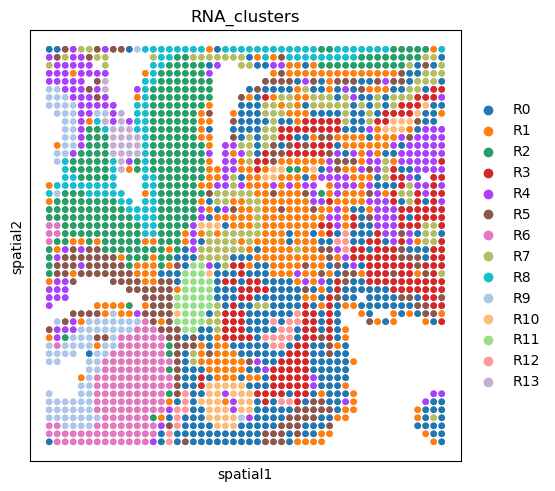

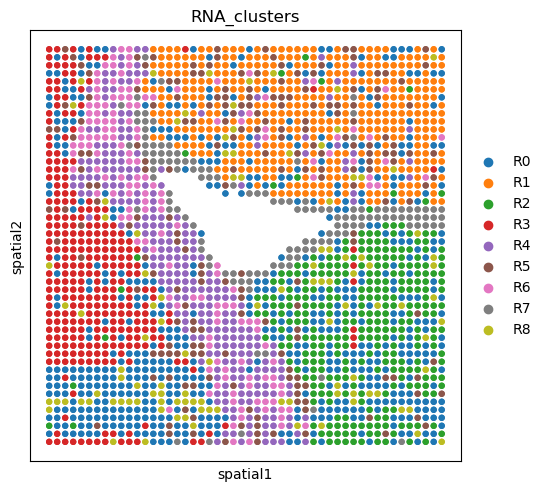

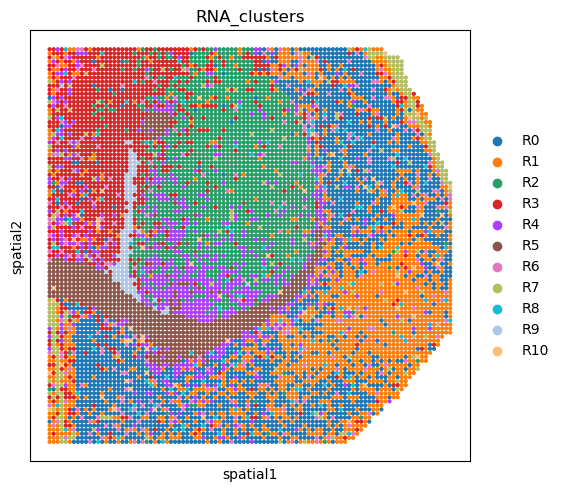

In [36]:
for batch_idx in batch_indeces:
    adata_rna = sc.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_batch{batch_idx}_rna.h5ad")
    
    print(f"Exploring dataset {dataset}_batch{batch_idx}_rna .")
    print(f"Number of nodes (cells): {adata_rna.X.shape[0]}")
    print(f"Number of node features (genes): {adata_rna.X.shape[1]}")

    # Visualize cell-level annotated data in physical space
    sq.pl.spatial_scatter(adata_rna, color="RNA_clusters", shape=None)        

Exploring dataset spatial_atac_rna_seq_mouse_embryo_and_brain_batch1_atac .
Number of nodes (cells): 2187
Number of node features (genes): 24017
Exploring dataset spatial_atac_rna_seq_mouse_embryo_and_brain_batch2_atac .
Number of nodes (cells): 2373
Number of node features (genes): 24023
Exploring dataset spatial_atac_rna_seq_mouse_embryo_and_brain_batch3_atac .
Number of nodes (cells): 9215
Number of node features (genes): 24027


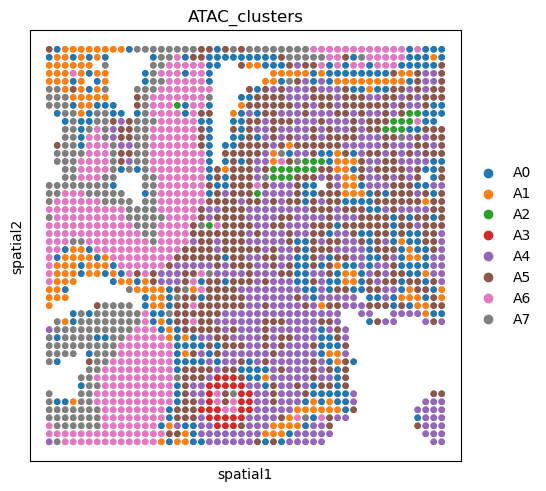

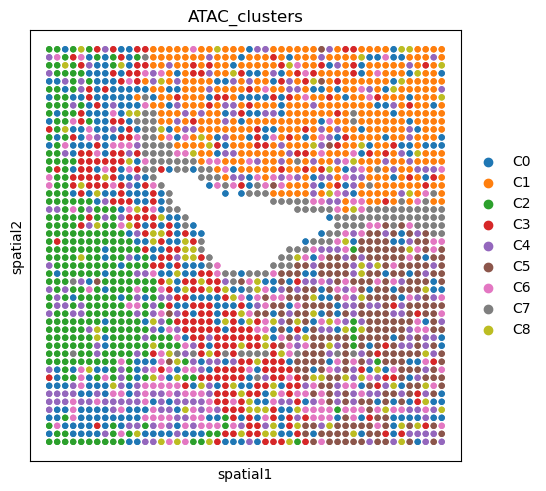

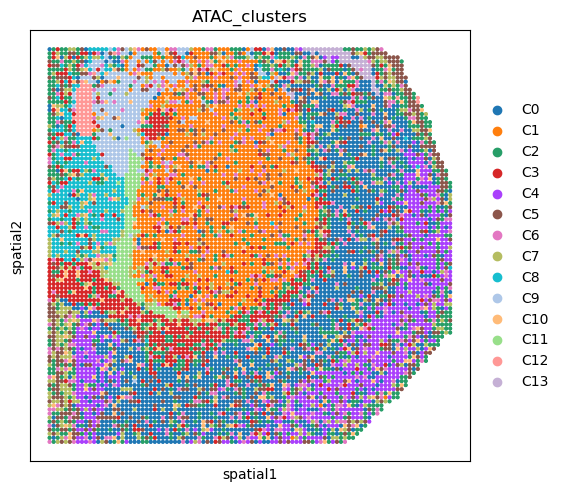

In [40]:
for batch_idx in batch_indeces:
    adata_atac = sc.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_batch{batch_idx}_atac.h5ad")
    
    print(f"Exploring dataset {dataset}_batch{batch_idx}_atac .")
    print(f"Number of nodes (cells): {adata_atac.X.shape[0]}")
    print(f"Number of node features (genes): {adata_atac.X.shape[1]}")

    # Visualize cell-level annotated data in physical space
    sq.pl.spatial_scatter(adata_atac, color="ATAC_clusters", shape=None)        

## 3. Additional Data

This data is not used as part of the publication.

### 3.2 Vizgen MERFISH Mouse Brain Receptor Dataset

- **Publication:** Vizgen Data Release V1.0. May 2021
- **Data Access:** https://info.vizgen.com/mouse-brain-map?submissionGuid=a66ccb7f-87cf-4c55-83b9-5a2b6c0c12b9
    - Slice 1 replicate 1
        - cell_by_gene_S1R1.csv
        - cell_metadata_S1R1.csv
- **Preprocessing Vignette:** https://squidpy.readthedocs.io/en/latest/external_tutorials/tutorial_vizgen.html
- **Summary:**
    - Coronal section of mouse brain receptor map
    - 78,329 observations on cell-level without annotations
    - 649 probed genes

In [ ]:
dataset = "vizgen_merfish_mouse_brain"
cell_type_key = "leiden"

#### 3.2.1 Load & Preprocess Raw Data

In [ ]:
print(f"Loading and preprocessing dataset '{dataset}'.")

# Read adata from files
merfish_dir = f"{srt_data_bronze_folder_path}/merfish/"
adata = sq.read.vizgen(path=merfish_dir,
                       counts_file="datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_replicate1_cell_by_gene_S1R1.csv",
                       meta_file="datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_replicate1_cell_metadata_S1R1.csv")
# Preprocess as per squidpy vignette
adata.var_names.unique()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=(50, 100, 200, 300), inplace=True)
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(adata.obs["total_counts"],
             kde=False,
             ax=axs[0])
sns.histplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000],
             kde=False,
             bins=40,
             ax=axs[1])
sns.histplot(adata.obs["n_genes_by_counts"],
             kde=False,
             bins=60,
             ax=axs[2])
sns.histplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
             kde=False,
             bins=60,
             ax=axs[3])
sc.pp.filter_cells(adata, min_counts=10)
sc.pp.filter_genes(adata, min_cells=10)

# Store raw counts in `layers`
adata.layers["counts"] = adata.X.copy()

# Store data to disk
adata.write(f"{srt_data_silver_folder_path}/{dataset}.h5ad")

# Determine cell annotation as per squidpy vignette
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=4000)
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata,
           color=["total_counts", "n_genes_by_counts", "leiden"])

# Store data to disk
adata.write(f"{srt_data_gold_folder_path}/{dataset}.h5ad")

#### 3.2.2 Explore Data

In [ ]:
print(f"Exploring dataset {dataset}.")
print(f"Number of nodes (cells): {adata.layers['counts'].shape[0]}")
print(f"Number of node features (genes): {adata.layers['counts'].shape[1]}")

# Visualize cell-level annotated data in physical space
sq.pl.spatial_scatter(adata, color=cell_type_key, shape=None, figsize=(12, 12))

### 3.3 Vizgen MERFISH Human Liver Cancer Dataset

- **Publication:** Vizgen MERFISH FFPE Human Immuno-oncology Data Set,  May 2022
- **Data Access:** https://info.vizgen.com/ffpe-showcase?submissionGuid=bbe0d6ca-92ad-4257-bdcd-cbc6dee8219b
    - Liver cancer 1
        - cell_by_gene.csv
        - cell_metadata.csv
- **Summary:**
    - FFPE tissue section of human liver cancer
    - 480,592 observations on cell-level without annotations
    - 500 probed genes

In [ ]:
dataset = "vizgen_merfish_human_liver_cancer"
cell_type_key = "leiden"

#### 3.3.1 Load & Preprocess Raw Data

In [ ]:
print(f"Loading and preprocessing dataset '{dataset}'.")
    
# Read counts and remove blank genes
vizgen_dir = f"{srt_data_bronze_folder_path}/merfish/"
adata = ad.read_text(vizgen_dir + "HumanLiverCancerPatient1_cell_by_gene.csv" ,delimiter=",", first_column_names=True)
blank_genes = np.array(["Blank" in v for v in adata.var_names])
adata.obsm["blank_genes"] = pd.DataFrame(adata[:, blank_genes].X.copy(), columns=adata.var_names[blank_genes], index=adata.obs_names)
adata = adata[:, ~blank_genes].copy()
adata.X = sp.csr_matrix(adata.X)

# Read metadata and align index for join
metadata = pd.read_csv(vizgen_dir + "HumanLiverCancerPatient1_cell_metadata.csv", header=0, index_col=0)
metadata.sort_index(inplace=True)
metadata.index = metadata.index.astype("str")

# Join counts with obs and store spatial coordinates
adata.obs = pd.merge(adata.obs, metadata, how="left", left_index=True, right_index=True)
adata.obsm["spatial"] = adata.obs[["center_x", "center_y"]].values
adata.obs.drop(columns=["center_x", "center_y"], inplace=True)

# Preprocess
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=(50, 100, 200, 300), inplace=True)
sc.pp.filter_cells(adata, min_counts=50)
sc.pp.filter_genes(adata, min_cells=10)

# Store raw counts in `layers`
adata.layers["counts"] = adata.X.copy()

# Store data to disk
adata.write(f"{srt_data_silver_folder_path}/{dataset}.h5ad")

# Determine cell annotation
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata,
           color=["total_counts", "n_genes_by_counts", "leiden"])

# Store data to disk
adata.write(f"{srt_data_gold_folder_path}/{dataset}.h5ad")

#### 3.3.2 Explore Data

In [ ]:
print(f"Exploring dataset {dataset}.")
print(f"Number of nodes (cells): {adata.layers['counts'].shape[0]}")
print(f"Number of node features (genes): {adata.layers['counts'].shape[1]}")

# Visualize cell-level annotated data in physical space
sq.pl.spatial_scatter(adata, color=cell_type_key, shape=None, figsize=(12, 12))

### 3.4 10x Genomics Xenium Human Breast Cancer Tumor Microenvironment Dataset

- **Publication:** Janesick, A. et al. High resolution mapping of the breast cancer tumor microenvironment using integrated single cell, spatial and in situ analysis of FFPE tissue. bioRxiv 2022.10.06.510405 (2022). [doi:10.1101/2022.10.06.510405](https://doi.org/10.1101/2022.10.06.510405)
- **Data Access:** https://www.10xgenomics.com/products/xenium-in-situ/preview-dataset-human-breast
    - Feature-cell matrix (HDF5)
    - Cell summary file (CSV) -> unpack with ```gzip -d Xenium_FFPE_Human_Breast_Cancer_z2_cells.csv.gz```
- **Preprocessing Vignette:** https://squidpy.readthedocs.io/en/latest/external_tutorials/tutorial_xenium.html
- **Summary**:
    - FFPE tissue section of human breast cancer
    - 164,079 observations on cell-level without annotations
    - 313 probed genes

In [ ]:
dataset = "10x_xenium_human_breast_cancer"
cell_type_key = "leiden"

#### 3.4.1 Load & Preprocess Raw Data

In [ ]:
print(f"Loading and preprocessing dataset '{dataset}'.")

# Read adata from file and add metadata
xenium_dir = f"{srt_data_bronze_folder_path}/xenium/"
adata = sc.read_10x_h5(filename=xenium_dir + "Xenium_FFPE_Human_Breast_Cancer_z2_cell_feature_matrix.h5")
metadata = pd.read_csv(xenium_dir + "Xenium_FFPE_Human_Breast_Cancer_z2_cells.csv")
metadata.set_index(adata.obs_names, inplace=True)
adata.obs = metadata.copy()

# Preprocess as per squidpy vignette
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"],percent_top=(50, 100, 200, 300), inplace=True)
sc.pp.filter_cells(adata, min_counts=10)
sc.pp.filter_genes(adata, min_cells=5)

# Store counts in `layers` and spatial coords in `obsm`
adata.layers["counts"] = adata.X.copy()
adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

# Store data to disk
adata.write(f"{srt_data_silver_folder_path}/{dataset}.h5ad")

# Determine cell annotation as per squidpy vignette
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

# Store data to disk
adata.write(f"{srt_data_gold_folder_path}/{dataset}.h5ad")

#### 3.4.2 Explore Data

In [ ]:
print(f"Exploring dataset {dataset}.")
print(f"Number of nodes (cells): {adata.layers['counts'].shape[0]}")
print(f"Number of node features (genes): {adata.layers['counts'].shape[1]}")

# Visualize cell-level annotated data in physical space
sq.pl.spatial_scatter(adata, color=cell_type_key, shape=None, figsize=(12, 12))

### 3.5 EEL FISH Mouse Brain Dataset

- **Publication:** Borm, L. E. et al. Scalable in situ single-cell profiling by electrophoretic capture of mRNA using EEL FISH. Nat. Biotechnol. (2022) [doi:10.1038/s41587-022-01455-3](https://doi.org/10.1038/s41587-022-01455-3)
- **Data Access:** https://figshare.com/articles/dataset/EEL_Mouse_440_genes_single_cell_data/20310771
    - LBEXP20210718_EEL_Mouse_448_2_20220512.h5ad
- **Summary:**
    - Sagittal mouse brain section
    - 127,591 observations on cell-level with cluster annotations 
    - 440 genes

In [ ]:
dataset = "eel_fish_mouse_brain"
cell_type_key = "Clusters"

#### 3.5.1 Load & Preprocess Raw Data

In [ ]:
print(f"Loading and preprocessing dataset '{dataset}'.")
    
# Read adata from file
adata = sc.read_h5ad(f"{srt_data_bronze_folder_path}/eel_fish_mouse_brain/LBEXP20210718_EEL_Mouse_448_2_20220512.h5ad")

# Store counts in `layers` and spatial coords in `obsm`
adata.obsm["spatial"] = adata.obs[["X", "Y"]].values # smaller scale for plotting with squidpy
adata.obs.drop(columns=["X", "Y", "X_um", "Y_um"], inplace=True)
adata.layers["counts"] = adata.X.copy()
adata.obs["batch"] = "sample1"

# Store data to disk
adata.write(f"{srt_data_gold_folder_path}/{dataset}.h5ad")

#### 3.5.2 Explore Data

In [ ]:
print(f"Exploring dataset {dataset}.")
print(f"Number of nodes (cells): {adata.layers['counts'].shape[0]}")
print(f"Number of node features (genes): {adata.layers['counts'].shape[1]}")

# Visualize cell-level annotated data in physical space
sq.pl.spatial_scatter(adata, color=cell_type_key, shape=None, figsize=(12, 12))